In [1]:
import arviz as az
import numpy as np
import scipy.stats as stats
import pymc3 as pm

### Inference engine

In [2]:
np.random.seed(123)
trials = 100
theta_real = 0.5 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


### Plot trace

array([[<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

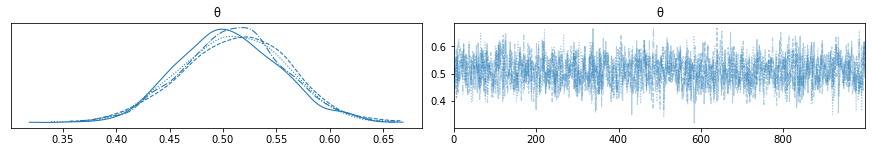

In [3]:
az.plot_trace(trace)

By using `az.plot_trace`, we get two subplots for each unobserved variable. The only unobserved variable in our model is $\theta$. Notice that $y$ is an observed variable representing the data; we do not need to sample that because we already know those values. 

Thus, in the above figure, we have two subplots. On the left, we have a Kernel Density Estimation (KDE) plot; this is like the smooth version of the histogram. On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior. 

The trace itself (the plot on the right) should look like white noise, meaning we should not see any recognizable pattern; we want a curve freely meandering around. When this happens, we say we have **good mixing**.

### Numerical summary

In [4]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.509,0.049,0.424,0.605,0.001,0.001,1677.0,2724.0,1.0


ArviZ provides several other plots to help interpret the trace. We may also want to have a numerical summary of the trace. We can get that using `az.summary`, which will return a pandas `DataFrame`.

We get the posterior mean, standard deviation (sd), and 94% HPD interval (hpd 3% and hpd 97%). The other metrics are related to diagnosing samples.

### Plot posterior

<AxesSubplot:title={'center':'θ'}>

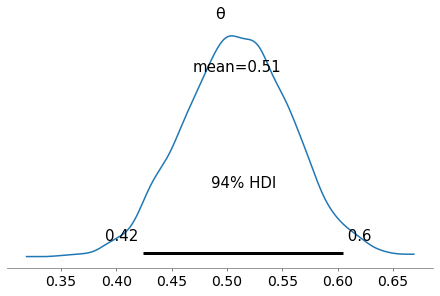

In [5]:
az.plot_posterior(trace)

Another way to visually summarize the posterior is to use the `plot_posterior` function that comes with ArviZ. 

By default, `plot_posterior()` shows a histogram for discrete variables and KDEs for continuous variables. We also get the mean of the distribution and the 94% HPD as a black line at the bottom of the plot. 

**HPD**

A commonly-used device to summarize the spread of a posterior distribution is to use a Highest-Posterior Density (HPD) interval. An HPD is the shortest interval containing a given portion of the probability density. One of the most commonly-used is the 95% HPD, often accompanied by the 50% HPD. If we say that the 95% HPD for some analysis is [2-5], we mean that according to our data and model, we think the parameter in question is between 2 and 5 with a probability of 0.95.

### Loss functions

In [6]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

KeyError: 'θ'

### Posterior predictive checks

One of the nice elements of the Bayesian toolkit is that once we have a posterior, it is possible to use the posterior  to generate predictions based on the data and the estimated parameters. 

The generated predictions can evidently be used when we need to make predictions, but we can also use them to criticize the models by comparing the observed data and the predicted data to spot differences between these two sets. This is known as **posterior predictive checks**. 